In [16]:
# Libraries 
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

# useful functions
def rounditup(x, precision, method):
    if method == "floor":
        return math.floor(x / precision) * precision
    elif method == "ceiling":
        return math.ceil(x / precision) * precision
    else:
        return "give the parameter floor or ceiling"

def spiciness(t, s):
    """
    Return spiciness as defined by Flament (2002).
    see : http://www.satlab.hawaii.edu/spice/spice.html
    ref : A state variable for characterizing water masses and their
          diffusive stability: spiciness. Progress in Oceanography
          Volume 54, 2002, Pages 493-501.
    test : spice(p=0,T=15,S=33)=0.54458641375
    NB : only for valid p = 0
    """
    B = np.zeros((7, 6))
    B[1, 1] = 0
    B[1, 2] = 7.7442e-001
    B[1, 3] = -5.85e-003
    B[1, 4] = -9.84e-004
    B[1, 5] = -2.06e-004

    B[2, 1] = 5.1655e-002
    B[2, 2] = 2.034e-003
    B[2, 3] = -2.742e-004
    B[2, 4] = -8.5e-006
    B[2, 5] = 1.36e-005

    B[3, 1] = 6.64783e-003
    B[3, 2] = -2.4681e-004
    B[3, 3] = -1.428e-005
    B[3, 4] = 3.337e-005
    B[3, 5] = 7.894e-006

    B[4, 1] = -5.4023e-005
    B[4, 2] = 7.326e-006
    B[4, 3] = 7.0036e-006
    B[4, 4] = -3.0412e-006
    B[4, 5] = -1.0853e-006

    B[5, 1] = 3.949e-007
    B[5, 2] = -3.029e-008
    B[5, 3] = -3.8209e-007
    B[5, 4] = 1.0012e-007
    B[5, 5] = 4.7133e-008

    B[6, 1] = -6.36e-010
    B[6, 2] = -1.309e-009
    B[6, 3] = 6.048e-009
    B[6, 4] = -1.1409e-009
    B[6, 5] = -6.676e-010
    #
    t = np.array(t)
    s = np.array(s)
    #
    coefs = B[1:7, 1:6]
    sp = np.zeros(t.shape)
    ss = s - 35.
    bigT = np.ones(t.shape)
    for i in range(6):
        bigS = np.ones(t.shape)
        for j in range(5):
            sp += coefs[i, j] * bigT * bigS
            bigS *= ss
        bigT *= t
    return sp

In [17]:
# Function to handle plotting for each variable for the combined profiles
def plot_profile(ax, raw_data, binned_data, y_column, x_column, xlabel, mld, ylabel=True):
    # Raw data
    alpha = 0.3
    ax.scatter(raw_data[x_column], raw_data[y_column], color='black', alpha=alpha)
    
    # Binned data
    ax.plot(binned_data[x_column], binned_data[y_column], color='black')
    
    # MLD line
    ax.axhline(y=mld, color='red', linestyle='--', linewidth=2)
    
    # Plot features
    if ylabel:
        ax.set_ylabel('Pressure [dbar]', size=15)
    else:
        ax.set_ylabel('')
    
    ax.set_xlabel(xlabel, size=15)
    ax.tick_params(axis='both', labelsize=15)
    ax.invert_yaxis()
    ax.grid(True, which='both', linestyle=':', linewidth=0.5)

In [18]:
# add the cycle number to the ecopart dataset 
ecopart = pd.read_csv('/home/aaccardo/Accardo_et_al/Data/Ecopart_diagnostics_data_655.tsv', sep = '\t')

# Filter rows where the 'Profile' column contains the letter 'a'
ecopart = ecopart[ecopart['Profile'].str.contains('a', na=False)]
ecopart = ecopart[['Profile', 'Date_Time', 'Pressure [dbar]', 'MaP_abun', 'Map_POC_cont_mgC_m3', 'MiP_abun', 'Mip_POC_cont_mgC_m3']]
ecopart['Date_Time'] = pd.to_datetime(ecopart['Date_Time']).dt.strftime('%Y-%m-%d %H:%M:%S')
ecopart
profile_df = pd.read_csv('/home/aaccardo/Accardo_et_al/Data/list_of_profiles.csv', sep = ',')
profile_df['CYCLE_NUMBER'] = range(1, len(profile_df) + 1)
profile_df.rename(columns={'profile': 'Profile'}, inplace=True)
profile_df = profile_df[['Profile', 'CYCLE_NUMBER']]
ecopart = pd.merge(ecopart, profile_df, on = 'Profile')
ecopart['Pressure [dbar]'] = ecopart["Pressure [dbar]"].apply(lambda x: rounditup(x, 5, "floor"))
ecopart = ecopart.groupby(['Profile', 'Date_Time', 'Pressure [dbar]']).mean(numeric_only=True).reset_index()
ecopart = ecopart[['Profile', 'Pressure [dbar]', 'Date_Time', 'Map_POC_cont_mgC_m3', 'Mip_POC_cont_mgC_m3']]
ecopart

,Profile,Pressure [dbar],Date_Time,Map_POC_cont_mgC_m3,Mip_POC_cont_mgC_m3
0,0000a_WMO6903095,0,2021-04-13 14:01:29,0.000000,2.40240
1,0000a_WMO6903095,5,2021-04-13 14:01:29,0.090919,2.13270
2,0000a_WMO6903095,10,2021-04-13 14:01:29,0.192650,1.68200
3,0000a_WMO6903095,15,2021-04-13 14:01:29,0.092261,1.53510
4,0000a_WMO6903095,20,2021-04-13 14:01:29,0.061147,1.50160
...,...,...,...,...,...
32541,0183a_WMO6903095,980,2022-09-17 19:52:17,0.000000,0.56729
32542,0183a_WMO6903095,985,2022-09-17 19:52:17,0.000000,0.61345
32543,0183a_WMO6903095,990,2022-09-17 19:52:17,0.000000,0.55034
32544,0183a_WMO6903095,995,2022-09-17 19:52:17,0.000000,0.49943


In [19]:
conditions = (
    ((ecopart['Date_Time'] >= '2021-10-08') & (ecopart['Date_Time'] <= '2021-10-23')) |
    ((ecopart['Date_Time'] >= '2021-11-25') & (ecopart['Date_Time'] <= '2021-12-22')) |
    ((ecopart['Date_Time'] >= '2022-03-10') & (ecopart['Date_Time'] <= '2022-04-15'))
)

# Filter the DataFrame
event_df = ecopart[conditions]

event_profiles = sorted(event_df['Profile'].unique())
event_profiles

['0064a_WMO6903095',
 '0065a_WMO6903095',
 '0066a_WMO6903095',
 '0067a_WMO6903095',
 '0068a_WMO6903095',
 '0080a_WMO6903095',
 '0081a_WMO6903095',
 '0082a_WMO6903095',
 '0083a_WMO6903095',
 '0084a_WMO6903095',
 '0085a_WMO6903095',
 '0086a_WMO6903095',
 '0087a_WMO6903095',
 '0088a_WMO6903095',
 '0115a_WMO6903095',
 '0116a_WMO6903095',
 '0117a_WMO6903095',
 '0118a_WMO6903095',
 '0119a_WMO6903095',
 '0120a_WMO6903095',
 '0121a_WMO6903095',
 '0122a_WMO6903095',
 '0123a_WMO6903095',
 '0124a_WMO6903095',
 '0125a_WMO6903095',
 '0126a_WMO6903095']

In [20]:
# Do it for all the profiles 
all_profiles = ecopart['Profile'].unique().tolist()
print(all_profiles)

['0000a_WMO6903095', '0001a_WMO6903095', '0002a_WMO6903095', '0003a_WMO6903095', '0004a_WMO6903095', '0005a_WMO6903095', '0006a_WMO6903095', '0007a_WMO6903095', '0008a_WMO6903095', '0009a_WMO6903095', '0010a_WMO6903095', '0011a_WMO6903095', '0012a_WMO6903095', '0013a_WMO6903095', '0014a_WMO6903095', '0015a_WMO6903095', '0016a_WMO6903095', '0017a_WMO6903095', '0018a_WMO6903095', '0019a_WMO6903095', '0020a_WMO6903095', '0021a_WMO6903095', '0022a_WMO6903095', '0023a_WMO6903095', '0024a_WMO6903095', '0025a_WMO6903095', '0026a_WMO6903095', '0027a_WMO6903095', '0028a_WMO6903095', '0029a_WMO6903095', '0030a_WMO6903095', '0031a_WMO6903095', '0032a_WMO6903095', '0033a_WMO6903095', '0034a_WMO6903095', '0035a_WMO6903095', '0036a_WMO6903095', '0037a_WMO6903095', '0038a_WMO6903095', '0039a_WMO6903095', '0040a_WMO6903095', '0041a_WMO6903095', '0042a_WMO6903095', '0043a_WMO6903095', '0044a_WMO6903095', '0045a_WMO6903095', '0046a_WMO6903095', '0047a_WMO6903095', '0048a_WMO6903095', '0049a_WMO6903095',

In [21]:
# import AOU and merge to ecopart
AOU = pd.read_csv('/home/aaccardo/Accardo_et_al/Data/AOU.csv', sep = ',')
AOU = pd.merge(AOU, profile_df, on = 'CYCLE_NUMBER')
AOU.rename(columns={'Depth [m]': 'Pressure [dbar]'}, inplace=True)
AOU = AOU[['Profile', 'Pressure [dbar]', 'AOU µmol/kg']]
# bin 
AOU['Pressure [dbar]'] = AOU["Pressure [dbar]"].apply(lambda x: rounditup(x, 5, "floor"))
AOU = AOU.groupby(['Profile', 'Pressure [dbar]']).mean(numeric_only=True).reset_index()
AOU_cleaned = AOU.dropna(subset=['AOU µmol/kg'])
AOU_cleaned

,Profile,Pressure [dbar],AOU µmol/kg
0,0000a_WMO6903095,0,-9.206776
1,0000a_WMO6903095,5,-8.825477
2,0000a_WMO6903095,10,-8.686625
3,0000a_WMO6903095,15,-8.407697
4,0000a_WMO6903095,20,-8.048559
...,...,...,...
26473,0183a_WMO6903095,940,81.614506
26475,0183a_WMO6903095,950,81.099169
26477,0183a_WMO6903095,960,80.694923
26479,0183a_WMO6903095,970,80.896513


In [22]:
# import the mld and merge to ecopart 
mld = pd.read_csv('/home/aaccardo/Accardo_et_al/Data/station_clines.csv', sep = ',')
mld = pd.merge(mld, profile_df, on = 'CYCLE_NUMBER')
mld

,CYCLE_NUMBER,thermocline,pycnocline,strat_index,DCM,MLD,temp_mld,chla_dcm_stock,Profile
0,1,82.5,82.5,2.076158,52.5,2.5,20.940880,5.624763,0000a_WMO6903095
1,2,77.5,77.5,2.023562,47.5,22.5,20.737955,7.855895,0001a_WMO6903095
2,3,77.5,77.5,2.017215,47.5,37.5,20.692597,6.028683,0002a_WMO6903095
3,4,82.5,82.5,1.989359,42.5,52.5,20.714832,5.390101,0003a_WMO6903095
4,5,77.5,77.5,2.045083,52.5,17.5,20.830618,5.879805,0004a_WMO6903095
...,...,...,...,...,...,...,...,...,...
178,180,837.5,432.5,0.045769,17.5,152.5,15.992187,11.497500,0179a_WMO6903095
179,181,322.5,402.5,0.054117,2.5,152.5,16.044897,10.501050,0180a_WMO6903095
180,182,722.5,432.5,0.052668,2.5,82.5,16.021856,12.264000,0181a_WMO6903095
181,183,402.5,412.5,0.056647,2.5,72.5,16.070471,16.019850,0182a_WMO6903095


In [23]:
# import spiciness and merge to ecopart 
# import ctd for spiciness compuation 
ctd = pd.read_csv('/home/aaccardo/Accardo_et_al/Data/bgc_benguela_clean.csv', sep = ';')
# compute spiciness
ctd['spiciness'] = spiciness(ctd['POT_TEMP'], ctd['PSAL'])
ctd.rename(columns={'binned_depth': 'Pressure [dbar]'}, inplace=True)
ctd = pd.merge(ctd, profile_df, on = 'CYCLE_NUMBER')
ctd['Pressure [dbar]'] = ctd["Pressure [dbar]"].apply(lambda x: rounditup(x, 5, "floor"))
ctd = ctd.groupby(['Profile', 'Pressure [dbar]']).mean(numeric_only=True).reset_index()
ctd_cleaned = ctd.dropna(subset=['spiciness'])
ctd_cleaned = ctd_cleaned[['Profile', 'Pressure [dbar]', 'spiciness', 'CHLA_ADJUSTED']]
ctd_cleaned

,Profile,Pressure [dbar],spiciness,CHLA_ADJUSTED
0,0000a_WMO6903095,0,3.940139,0.189800
1,0000a_WMO6903095,5,3.905716,0.189800
2,0000a_WMO6903095,10,3.872959,0.189800
3,0000a_WMO6903095,15,3.882450,0.185188
4,0000a_WMO6903095,20,3.925115,0.133612
...,...,...,...,...
26477,0183a_WMO6903095,960,0.000373,0.000000
26478,0183a_WMO6903095,965,-0.013569,NaN
26479,0183a_WMO6903095,970,-0.020908,0.000000
26480,0183a_WMO6903095,975,-0.037572,0.000000


In [24]:
# Import bbp data 
bbp = pd.read_csv('/home/aaccardo/Accardo_et_al/Data/bbp_decomposed.csv')
bbp = pd.merge(bbp, profile_df, on  = 'CYCLE_NUMBER')
bbp.rename(columns={'PRES': 'Pressure [dbar]'}, inplace=True)
bbp = bbp[['Profile', 'Pressure [dbar]', 'bbsr']]
bbp['Pressure [dbar]'] = bbp["Pressure [dbar]"].apply(lambda x: rounditup(x, 5, "floor"))
bbp = bbp.groupby(['Profile', 'Pressure [dbar]']).mean(numeric_only=True).reset_index()
bbp_cleaned = bbp.dropna(subset=['bbsr'])
bbp

,Profile,Pressure [dbar],bbsr
0,0000a_WMO6903095,0,0.000673
1,0000a_WMO6903095,5,0.000733
2,0000a_WMO6903095,10,0.000792
3,0000a_WMO6903095,15,0.000815
4,0000a_WMO6903095,20,0.000819
...,...,...,...
21188,0183a_WMO6903095,965,0.000276
21189,0183a_WMO6903095,975,0.000276
21190,0183a_WMO6903095,985,0.000276
21191,0183a_WMO6903095,990,0.000276


In [25]:
def plot_profile(ax, data, raw_column, roll_column, pressure, xlabel, mld, second_raw_data=None, second_binned_data=None, second_x_column=None, second_xlabel=None, ylabel=True, second_color='blue', primary_color='black'):
    
    # Raw data for the primary variable
    alpha = 0.3
    ax.scatter(data[raw_column], data[pressure], color=primary_color, alpha=alpha, label=xlabel)
    ax.plot(data[roll_column], data[pressure], color=primary_color)
    
    # MLD line
    ax.axhline(y=mld, color='red', linestyle='--', linewidth=2)
    
    # Plot features for primary axis
    if ylabel:
        ax.set_ylabel('Pressure [dbar]', size=15)
    else:
        ax.set_ylabel('')
    
    ax.set_xlabel(xlabel, size=15, color=primary_color)
    ax.tick_params(axis='x', labelsize=15, colors=primary_color)

    # set the y axis limit to max 1000m
    max_pressure = data[pressure].max()
    
    if max_pressure > 1000:
        ax.set_ylim(0, 1000)
    else:
        ax.set_ylim(0, max_pressure)
    
    ax.invert_yaxis()
    ax.grid(True, which='both', linestyle=':', linewidth=0.5)

    # clip x axis if chlorophyll is plotted
    if raw_column == 'CHLA_ADJUSTED':
        ax.set_xlim(0, 0.1)
        
    # If a second variable is provided, add a second x-axis at the top
    if second_x_column and second_raw_data is not None and second_binned_data is not None:
        ax2 = ax.twiny()  # Create a twin x-axis sharing the y-axis
        ax2.scatter(second_raw_data[second_x_column], second_raw_data[y_column], color=second_color, alpha=alpha, label=second_xlabel)
        ax2.plot(second_binned_data[second_x_column], second_binned_data[y_column], color=second_color)
        
        # Set up the second x-axis properties
        ax2.set_xlabel(second_xlabel, size=15, color=second_color)
        ax2.tick_params(axis='x', labelsize=15, colors=second_color)
        ax2.grid(True, which='both', linestyle=':', linewidth=0.5)

def plot_anomaly(ax, data, diff_column, pressure, xlabel, mld, ylabel=True):
    
    # Raw data for the primary variable
    alpha = 0.3
    # ax.scatter(data[raw_column], data[pressure], color=primary_color, alpha=alpha, label=xlabel)
    ax.plot(data[diff_column], data[pressure], color='black')
    
    # MLD line
    if mld:
        ax.axhline(y=mld, color='red', linestyle='--', linewidth=2)
    
    # Add vertical line at x = 0
    ax.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
    
    # Ensure the plot is drawn before setting background colors
    ax.figure.canvas.draw()
    
    # Get the current x-axis limits
    x_min, x_max = ax.get_xlim()
    
    # Color background based on x values
    ax.axvspan(x_min, 0, color='blue', alpha=0.1)  # Shade for x < 0
    ax.axvspan(0, x_max, color='red', alpha=0.1)   # Shade for x > 0
    
    # Plot features for primary axis
    if ylabel:
        ax.set_ylabel('Pressure [dbar]', size=15)
    else:
        ax.set_ylabel('')
    
    ax.set_xlabel(xlabel, size=15, color='black')
    ax.tick_params(axis='x', labelsize=15, colors='black')
    ax.set_ylim(0, 1000)
    ax.invert_yaxis()
    ax.grid(True, which='both', linestyle=':', linewidth=0.5)

# Initialize global datasets
global_rolling_df = pd.DataFrame()
global_AOU_rolling = pd.DataFrame()
global_ctd_rolling = pd.DataFrame()
global_bbp_rolling = pd.DataFrame()

for profile in all_profiles:
    print('Processing profile: ', profile)
    df = ecopart[ecopart['Profile'] == profile]
    df = df[df['Pressure [dbar]'] <= 1000]
    # Sort the data by pressure to ensure the running mean is applied in order
    df = df.sort_values(by='Pressure [dbar]')
    
    # Apply the rolling with size = 3
    window_size = 3
    min_periods = 1
    rolling_df = df.copy()
    rolling_df[['Map_POC_cont_mgC_m3_roll_3', 'Mip_POC_cont_mgC_m3_roll_3']] = df[['Map_POC_cont_mgC_m3', 'Mip_POC_cont_mgC_m3']].rolling(window=window_size, min_periods=min_periods).mean()

    # Apply the rolling with size = 20
    window_size = 20
    min_periods = 1
    rolling_df[['Map_POC_cont_mgC_m3_roll_20', 'Mip_POC_cont_mgC_m3_roll_20']] = df[['Map_POC_cont_mgC_m3', 'Mip_POC_cont_mgC_m3']].rolling(window=window_size, min_periods=min_periods).mean()

    '''
    # Compute the difference
    column_prefixes = ['MaP_abun', 'Map_POC_cont_mgC_m3', 'MiP_abun', 'Mip_POC_cont_mgC_m3']
    for prefix in column_prefixes:
        rolling_df[f'{prefix}_diff'] = df[prefix] - rolling_df[f'{prefix}_roll'] 
    '''
    # Concatenate to the global dataset
    global_rolling_df = pd.concat([global_rolling_df, rolling_df], ignore_index=True)

    # compute the difference 
    global_rolling_df['MaP_POC_diff'] = global_rolling_df['Map_POC_cont_mgC_m3_roll_3'] - global_rolling_df['Map_POC_cont_mgC_m3_roll_20']
    global_rolling_df['MiP_POC_diff'] = global_rolling_df['Mip_POC_cont_mgC_m3_roll_3'] - global_rolling_df['Mip_POC_cont_mgC_m3_roll_20']

    # compute the difference 
    #global_rolling_df['MaP_POC_diff'] = global_rolling_df['Map_POC_cont_mgC_m3_roll_20'] - global_rolling_df['Map_POC_cont_mgC_m3_roll_3']
    #global_rolling_df['MiP_POC_diff'] = global_rolling_df['Mip_POC_cont_mgC_m3_roll_20'] - global_rolling_df['Mip_POC_cont_mgC_m3_roll_3']

    # AOU data
    AOU_df = AOU_cleaned[AOU_cleaned['Profile'] == profile]
    AOU_df = AOU_df[AOU_df['Pressure [dbar]'] <= 1000]
    AOU_df = AOU_df.sort_values(by='Pressure [dbar]')
    AOU_rolling = AOU_df.copy()
    
    # Apply the rolling with size = 3
    window_size = 3
    min_periods = 1
    AOU_rolling[['AOU µmol/kg_roll_3']] = AOU_rolling[['AOU µmol/kg']].rolling(window=window_size, min_periods=min_periods).mean()

    # Apply the rolling with size = 20
    window_size = 20
    min_periods = 1
    AOU_rolling[['AOU µmol/kg_roll_20']] = AOU_rolling[['AOU µmol/kg']].rolling(window=window_size, min_periods=min_periods).mean()
    
    # Concatenate to the global dataset
    global_AOU_rolling = pd.concat([global_AOU_rolling, AOU_rolling], ignore_index=True)
    global_AOU_rolling['AOU_diff'] = global_AOU_rolling['AOU µmol/kg_roll_3'] - global_AOU_rolling['AOU µmol/kg_roll_20']
    #global_AOU_rolling['AOU_diff'] = global_AOU_rolling['AOU µmol/kg_roll_20'] - global_AOU_rolling['AOU µmol/kg_roll_3']
    # BGC variables
    ctd_df = ctd_cleaned[ctd_cleaned['Profile'] == profile]
    ctd_df = ctd_df[ctd_df['Pressure [dbar]'] <= 1000]
    ctd_df = ctd_df.sort_values(by='Pressure [dbar]')
    ctd_rolling = ctd_df.copy()
    
    # Apply the rolling with size = 3
    window_size = 3
    min_periods = 1    
    ctd_rolling[['spiciness_roll_3', 'CHLA_ADJUSTED_roll_3']] = ctd_rolling[['spiciness', 'CHLA_ADJUSTED']].rolling(window=window_size, min_periods=min_periods).mean()

    # Apply the rolling with size = 20
    window_size = 20
    min_periods = 1    
    ctd_rolling[['spiciness_roll_20', 'CHLA_ADJUSTED_roll_20']] = ctd_rolling[['spiciness', 'CHLA_ADJUSTED']].rolling(window=window_size, min_periods=min_periods).mean()
    
    # Concatenate to the global dataset
    global_ctd_rolling = pd.concat([global_ctd_rolling, ctd_rolling], ignore_index=True)

    # compute the difference 
    global_ctd_rolling['spiciness_diff'] = global_ctd_rolling['spiciness_roll_3'] - global_ctd_rolling['spiciness_roll_20']
    global_ctd_rolling['chla_diff'] = global_ctd_rolling['CHLA_ADJUSTED_roll_3'] - global_ctd_rolling['CHLA_ADJUSTED_roll_20']
    # compute the difference 
    #global_ctd_rolling['spiciness_diff'] = global_ctd_rolling['spiciness_roll_20'] - global_ctd_rolling['spiciness_roll_3']
    #global_ctd_rolling['chla_diff'] = global_ctd_rolling['CHLA_ADJUSTED_roll_20'] - global_ctd_rolling['CHLA_ADJUSTED_roll_3']    
    # bbp 
    bbp_df = bbp_cleaned[bbp_cleaned['Profile'] == profile]
    bbp_df = bbp_df[bbp_df['Pressure [dbar]'] <= 1000]
    bbp_df = bbp_df.sort_values(by='Pressure [dbar]')
    bbp_rolling = bbp_df.copy()

    # Apply the rolling with size = 3
    window_size = 3
    min_periods = 1   
    
    bbp_rolling[['bbsr_roll_3']] = bbp_rolling[['bbsr']].rolling(window=window_size, min_periods=min_periods).mean()
    
    # Apply the rolling with size = 3
    window_size = 20
    min_periods = 1   
    
    bbp_rolling[['bbsr_roll_20']] = bbp_rolling[['bbsr']].rolling(window=window_size, min_periods=min_periods).mean() 
    
    # Concatenate to the global dataset
    global_bbp_rolling = pd.concat([global_bbp_rolling, bbp_rolling], ignore_index=True)
    
    # compute the difference 
    global_bbp_rolling['bbsr_diff'] = global_bbp_rolling['bbsr_roll_3'] - global_bbp_rolling['bbsr_roll_20']    
    #global_bbp_rolling['bbsr_diff'] = global_bbp_rolling['bbsr_roll_20'] - global_bbp_rolling['bbsr_roll_3']       
    # MLD
    mld_df = mld[mld['Profile'] == profile]
    mld_df = mld_df[['MLD']]
    
    try:
        mld_value = mld_df.iloc[0, 0]
    except:
        print(f'no mld value for {profile}')
        continue
    
    '''
    # Create the figure and axes with shared x-axis for each pair
    fig, axes = plt.subplots(1, 6, figsize=(30, 10), sharex='col', sharey='row')
    
    # Titles for each profile
    fig.text(0.5, 0.9, f'{profile}', ha='center', fontsize=20, fontweight='bold')

    # Spiciness and Dens on the first subplot
    plot_profile(axes[0], ctd_rolling, 'spiciness', 'spiciness_roll', 'Pressure [dbar]', r'Spiciness ($kg\cdot$m$^{-3}$)', mld_value)
    #plot_anomaly(axes[0], ctd_rolling, 'spiciness_diff', 'Pressure [dbar]', r'Spiciness anomaly ($kg\cdot$m$^{-3}$)', mld_value, ylabel = True)
    
    # AOU (from AOU_df) and DOXY_ADJUSTED (from ctd_df) on the second subplot
    plot_profile(axes[1], AOU_rolling, 'AOU µmol/kg', 'AOU µmol/kg_roll', 'Pressure [dbar]', r'AOU ($µmol\cdot$kg$^{-1}$)', mld_value, ylabel = False)
    #plot_anomaly(axes[1], AOU_rolling, 'AOU µmol/kg_diff', 'Pressure [dbar]', r'AOU anomaly ($µmol\cdot$kg)', mld_value, ylabel = False)
    
    # bbsr
    plot_profile(axes[2], bbp_rolling, 'bbsr', 'bbsr_roll', 'Pressure [dbar]', r'bbsr (m$^{-1}$)', mld_value, ylabel=False)
    #plot_anomaly(axes[2], bbp_rolling, 'bbsr_diff', 'Pressure [dbar]', r'bbsr anomaly (m$^{-1}$)', mld_value, ylabel = False)
    
    # chla
    plot_profile(axes[3], ctd_rolling, 'CHLA_ADJUSTED', 'CHLA_ADJUSTED_roll', 'Pressure [dbar]', r'Chlorophyll-a ($mg\cdot$m$^{-3}$)', mld_value, ylabel=False)
    #plot_anomaly(axes[3], ctd_rolling, 'CHLA_ADJUSTED_diff', 'Pressure [dbar]', r'Chlorophyll-a anomaly ($mg\cdot$m$^{-3}$)', mld_value, ylabel = False)
    
    # MaP
    plot_profile(axes[4], rolling_df, 'Map_POC_cont_mgC_m3', 'Map_POC_cont_mgC_m3_roll', 'Pressure [dbar]', r'MaP POC ($mgC\cdot$m$^{-3}$)', mld_value, ylabel=False)
    #plot_anomaly(axes[4], rolling_df, 'Map_POC_cont_mgC_m3_diff', 'Pressure [dbar]', r'MaP POC anomaly ($mgC\cdot$m$^{-3}$)', mld_value, ylabel = False)
    
    # MiP
    plot_profile(axes[5], rolling_df, 'Mip_POC_cont_mgC_m3', 'Mip_POC_cont_mgC_m3_roll', 'Pressure [dbar]', r'MiP POC ($mgC\cdot$m$^{-3}$)', mld_value, ylabel=False)
    #plot_anomaly(axes[5], rolling_df, 'Mip_POC_cont_mgC_m3_diff', 'Pressure [dbar]', r'MiP POC anomaly ($mgC\cdot$m$^{-3}$)', mld_value, ylabel = False)

    # Save or show plot
    plt.savefig(f'/home/aaccardo/Accardo_et_al/Figures/profiles_plots/{profile}.png', dpi=300)
    #plt.savefig(f'/home/aaccardo/Accardo_et_al/Figures/profile_anomalies/{profile}_ano.png', dpi=300)
    plt.close()
    #plt.show()
    '''

Processing profile:  0000a_WMO6903095
Processing profile:  0001a_WMO6903095
Processing profile:  0002a_WMO6903095
Processing profile:  0003a_WMO6903095
Processing profile:  0004a_WMO6903095
Processing profile:  0005a_WMO6903095
Processing profile:  0006a_WMO6903095
Processing profile:  0007a_WMO6903095
Processing profile:  0008a_WMO6903095
Processing profile:  0009a_WMO6903095
Processing profile:  0010a_WMO6903095
Processing profile:  0011a_WMO6903095
Processing profile:  0012a_WMO6903095
Processing profile:  0013a_WMO6903095
Processing profile:  0014a_WMO6903095
Processing profile:  0015a_WMO6903095
Processing profile:  0016a_WMO6903095
Processing profile:  0017a_WMO6903095
Processing profile:  0018a_WMO6903095
Processing profile:  0019a_WMO6903095
Processing profile:  0020a_WMO6903095
Processing profile:  0021a_WMO6903095
Processing profile:  0022a_WMO6903095
Processing profile:  0023a_WMO6903095
Processing profile:  0024a_WMO6903095
Processing profile:  0025a_WMO6903095
Processing p

In [26]:
global_rolling_df

,Profile,Pressure [dbar],Date_Time,Map_POC_cont_mgC_m3,Mip_POC_cont_mgC_m3,Map_POC_cont_mgC_m3_roll_3,Mip_POC_cont_mgC_m3_roll_3,Map_POC_cont_mgC_m3_roll_20,Mip_POC_cont_mgC_m3_roll_20,MaP_POC_diff,MiP_POC_diff
0,0000a_WMO6903095,0,2021-04-13 14:01:29,0.000000,2.40240,0.000000,2.402400,0.000000,2.402400,0.000000,0.000000
1,0000a_WMO6903095,5,2021-04-13 14:01:29,0.090919,2.13270,0.045459,2.267550,0.045459,2.267550,0.000000,0.000000
2,0000a_WMO6903095,10,2021-04-13 14:01:29,0.192650,1.68200,0.094523,2.072367,0.094523,2.072367,0.000000,0.000000
3,0000a_WMO6903095,15,2021-04-13 14:01:29,0.092261,1.53510,0.125277,1.783267,0.093957,1.938050,0.031319,-0.154783
4,0000a_WMO6903095,20,2021-04-13 14:01:29,0.061147,1.50160,0.115353,1.572900,0.087395,1.850760,0.027957,-0.277860
...,...,...,...,...,...,...,...,...,...,...,...
29877,0183a_WMO6903095,980,2022-09-17 19:52:17,0.000000,0.56729,0.000000,0.549627,0.002655,0.547018,-0.002655,0.002609
29878,0183a_WMO6903095,985,2022-09-17 19:52:17,0.000000,0.61345,0.000000,0.570000,0.002655,0.551937,-0.002655,0.018062
29879,0183a_WMO6903095,990,2022-09-17 19:52:17,0.000000,0.55034,0.000000,0.577027,0.002655,0.551272,-0.002655,0.025754
29880,0183a_WMO6903095,995,2022-09-17 19:52:17,0.000000,0.49943,0.000000,0.554407,0.002655,0.553277,-0.002655,0.001130


In [27]:
global_AOU_rolling['strong_ano_AOU'] = global_AOU_rolling['AOU_diff'] < -8
global_AOU_rolling

,Profile,Pressure [dbar],AOU µmol/kg,AOU µmol/kg_roll_3,AOU µmol/kg_roll_20,AOU_diff,strong_ano_AOU
0,0000a_WMO6903095,0,-9.206776,-9.206776,-9.206776,0.000000,False
1,0000a_WMO6903095,5,-8.825477,-9.016126,-9.016126,0.000000,False
2,0000a_WMO6903095,10,-8.686625,-8.906292,-8.906292,0.000000,False
3,0000a_WMO6903095,15,-8.407697,-8.639933,-8.781644,0.141711,False
4,0000a_WMO6903095,20,-8.048559,-8.380960,-8.635027,0.254066,False
...,...,...,...,...,...,...,...
20910,0183a_WMO6903095,940,81.614506,81.975999,73.801833,8.174166,False
20911,0183a_WMO6903095,950,81.099169,81.570750,74.721566,6.849184,False
20912,0183a_WMO6903095,960,80.694923,81.136199,75.493619,5.642580,False
20913,0183a_WMO6903095,970,80.896513,80.896868,76.133990,4.762878,False


In [28]:
global_ctd_rolling['strong_ano_spiciness'] = global_ctd_rolling['spiciness_diff'] < -0.05
global_ctd_rolling

,Profile,Pressure [dbar],spiciness,CHLA_ADJUSTED,spiciness_roll_3,CHLA_ADJUSTED_roll_3,spiciness_roll_20,CHLA_ADJUSTED_roll_20,spiciness_diff,chla_diff,strong_ano_spiciness
0,0000a_WMO6903095,0,3.940139,0.189800,3.940139,0.189800,3.940139,0.189800,0.000000,0.000000,False
1,0000a_WMO6903095,5,3.905716,0.189800,3.922928,0.189800,3.922928,0.189800,0.000000,0.000000,False
2,0000a_WMO6903095,10,3.872959,0.189800,3.906272,0.189800,3.906272,0.189800,0.000000,0.000000,False
3,0000a_WMO6903095,15,3.882450,0.185188,3.887042,0.188263,3.900316,0.188647,-0.013274,-0.000384,False
4,0000a_WMO6903095,20,3.925115,0.133612,3.893508,0.169533,3.905276,0.177640,-0.011768,-0.008107,False
...,...,...,...,...,...,...,...,...,...,...,...
25438,0183a_WMO6903095,960,0.000373,0.000000,0.013343,0.001825,0.176834,0.000730,-0.163491,0.001095,True
25439,0183a_WMO6903095,965,-0.013569,NaN,-0.000766,0.000000,0.157462,0.000782,-0.158227,-0.000782,True
25440,0183a_WMO6903095,970,-0.020908,0.000000,-0.011368,0.000000,0.137905,0.000782,-0.149274,-0.000782,True
25441,0183a_WMO6903095,975,-0.037572,0.000000,-0.024017,0.000000,0.118431,0.000782,-0.142447,-0.000782,True


In [29]:
merged_df = pd.merge(global_rolling_df, global_AOU_rolling, on=['Profile', 'Pressure [dbar]'], how='inner')

# Merge the result with the third dataset
merged_df = pd.merge(merged_df, global_ctd_rolling, on=['Profile', 'Pressure [dbar]'], how='inner')
merged_df = pd.merge(merged_df, global_bbp_rolling, on=['Profile', 'Pressure [dbar]'], how='inner')
merged_df['ESP'] = merged_df['strong_ano_AOU'] & merged_df['strong_ano_spiciness']
merged_df

,Profile,Pressure [dbar],Date_Time,Map_POC_cont_mgC_m3,Mip_POC_cont_mgC_m3,Map_POC_cont_mgC_m3_roll_3,Mip_POC_cont_mgC_m3_roll_3,Map_POC_cont_mgC_m3_roll_20,Mip_POC_cont_mgC_m3_roll_20,MaP_POC_diff,MiP_POC_diff,AOU µmol/kg,AOU µmol/kg_roll_3,AOU µmol/kg_roll_20,AOU_diff,strong_ano_AOU,spiciness,CHLA_ADJUSTED,spiciness_roll_3,CHLA_ADJUSTED_roll_3,spiciness_roll_20,CHLA_ADJUSTED_roll_20,spiciness_diff,chla_diff,strong_ano_spiciness,bbsr,bbsr_roll_3,bbsr_roll_20,bbsr_diff,ESP
0,0000a_WMO6903095,0,2021-04-13 14:01:29,0.000000,2.40240,0.000000,2.402400,0.000000,2.402400,0.000000,0.000000,-9.206776,-9.206776,-9.206776,0.000000,False,3.940139,0.189800,3.940139,0.189800,3.940139,0.189800,0.000000,0.000000,False,0.000673,0.000673,0.000673,0.000000e+00,False
1,0000a_WMO6903095,5,2021-04-13 14:01:29,0.090919,2.13270,0.045459,2.267550,0.045459,2.267550,0.000000,0.000000,-8.825477,-9.016126,-9.016126,0.000000,False,3.905716,0.189800,3.922928,0.189800,3.922928,0.189800,0.000000,0.000000,False,0.000733,0.000703,0.000703,0.000000e+00,False
2,0000a_WMO6903095,10,2021-04-13 14:01:29,0.192650,1.68200,0.094523,2.072367,0.094523,2.072367,0.000000,0.000000,-8.686625,-8.906292,-8.906292,0.000000,False,3.872959,0.189800,3.906272,0.189800,3.906272,0.189800,0.000000,0.000000,False,0.000792,0.000733,0.000733,0.000000e+00,False
3,0000a_WMO6903095,15,2021-04-13 14:01:29,0.092261,1.53510,0.125277,1.783267,0.093957,1.938050,0.031319,-0.154783,-8.407697,-8.639933,-8.781644,0.141711,False,3.882450,0.185188,3.887042,0.188263,3.900316,0.188647,-0.013274,-0.000384,False,0.000815,0.000780,0.000753,2.679961e-05,False
4,0000a_WMO6903095,20,2021-04-13 14:01:29,0.061147,1.50160,0.115353,1.572900,0.087395,1.850760,0.027957,-0.277860,-8.048559,-8.380960,-8.635027,0.254066,False,3.925115,0.133612,3.893508,0.169533,3.905276,0.177640,-0.011768,-0.008107,False,0.000819,0.000809,0.000766,4.232921e-05,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16313,0183a_WMO6903095,905,2022-09-17 19:52:17,0.000000,0.58845,0.000000,0.567110,0.005600,0.558277,-0.005600,0.008833,79.996229,78.708967,70.232247,8.476720,False,0.152365,0.000000,0.186647,0.000000,0.389845,0.000261,-0.203199,-0.000261,True,0.000266,0.000267,0.000267,-3.192467e-08,False
16314,0183a_WMO6903095,930,2022-09-17 19:52:17,0.000000,0.49471,0.000000,0.573860,0.000000,0.563512,0.000000,0.010347,81.998576,81.964618,72.942334,9.022284,False,0.109305,0.003650,0.129857,0.002433,0.319410,0.000684,-0.189553,0.001749,True,0.000276,0.000276,0.000269,7.379533e-06,False
16315,0183a_WMO6903095,940,2022-09-17 19:52:17,0.000000,0.50006,0.000000,0.513600,0.000000,0.559192,0.000000,-0.045592,81.614506,81.975999,73.801833,8.174166,False,0.067971,0.000000,0.090694,0.001825,0.270970,0.000684,-0.180276,0.001141,True,0.000276,0.000276,0.000270,6.951280e-06,False
16316,0183a_WMO6903095,950,2022-09-17 19:52:17,0.000000,0.53237,0.000000,0.542527,0.000000,0.557078,0.000000,-0.014551,81.099169,81.570750,74.721566,6.849184,False,0.028756,0.003650,0.047142,0.001825,0.221590,0.000913,-0.174449,0.000913,True,0.000276,0.000276,0.000270,6.523027e-06,False


Processing profile:  0000a_WMO6903095
Processing profile:  0001a_WMO6903095
Processing profile:  0002a_WMO6903095
Processing profile:  0003a_WMO6903095
Processing profile:  0004a_WMO6903095
Processing profile:  0005a_WMO6903095
Processing profile:  0006a_WMO6903095
Processing profile:  0007a_WMO6903095
Processing profile:  0008a_WMO6903095
Processing profile:  0009a_WMO6903095
Processing profile:  0010a_WMO6903095
Processing profile:  0011a_WMO6903095
Processing profile:  0012a_WMO6903095
Processing profile:  0013a_WMO6903095
Processing profile:  0014a_WMO6903095
Processing profile:  0015a_WMO6903095
Processing profile:  0016a_WMO6903095
Processing profile:  0017a_WMO6903095
Processing profile:  0018a_WMO6903095
Processing profile:  0019a_WMO6903095
Processing profile:  0020a_WMO6903095
Processing profile:  0021a_WMO6903095
Processing profile:  0022a_WMO6903095
Processing profile:  0023a_WMO6903095
Processing profile:  0024a_WMO6903095
Processing profile:  0025a_WMO6903095
Processing p

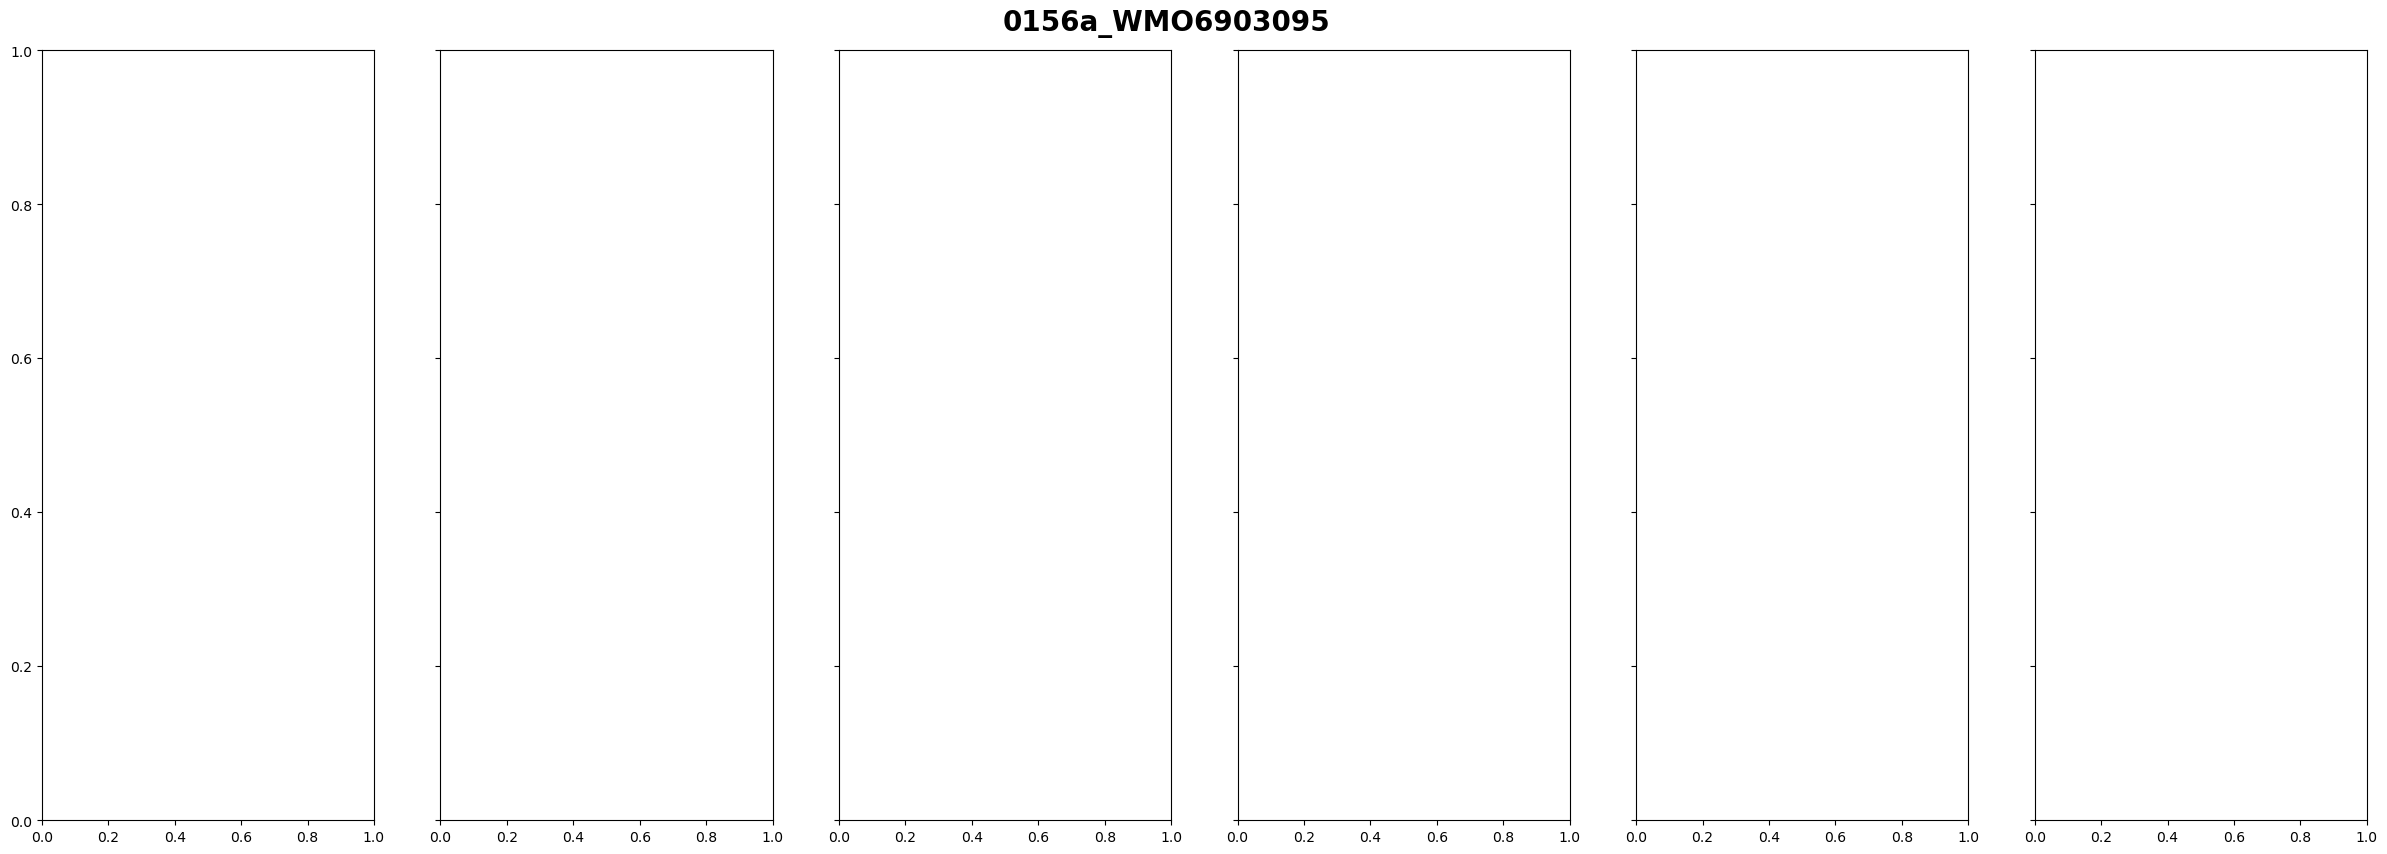

In [135]:
def plot_profile(ax, data, raw_column, roll_column, pressure, xlabel, mld, second_raw_data=None, second_binned_data=None, second_x_column=None, second_xlabel=None, ylabel=True, second_color='blue', primary_color='black', display_ano=False):
    
    # Raw data for the primary variable
    alpha = 0.3
    ax.scatter(data[raw_column], data[pressure], color=primary_color, alpha=alpha, label=xlabel)
    ax.plot(data[roll_column], data[pressure], color=primary_color)
    
    # MLD line
    ax.axhline(y=mld, color='red', linestyle='--', linewidth=2)
    
    # Plot features for primary axis
    if ylabel:
        ax.set_ylabel('Pressure [dbar]', size=15)
    else:
        ax.set_ylabel('')
    
    ax.set_xlabel(xlabel, size=15, color=primary_color)
    ax.tick_params(axis='x', labelsize=15, colors=primary_color)

    # Set the y axis limit to max 1000m
    max_pressure = data[pressure].max()
    
    if max_pressure > 1000:
        ax.set_ylim(0, 1000)
    else:
        ax.set_ylim(0, max_pressure)
    
    ax.invert_yaxis()
    ax.grid(True, which='both', linestyle=':', linewidth=0.5)

    # Clip x axis if chlorophyll is plotted
    if raw_column == 'CHLA_ADJUSTED_roll_3':
        ax.set_xlim(0, 0.1)
        
    # Highlight anomalies if display_ano is True
    if display_ano:
        # Identify the depths where strong anomalies are present
        strong_ano_mask = data['ESP']
        ax.fill_betweenx(
            data[pressure], 
            data[raw_column].min(), data[raw_column].max(), 
            where=strong_ano_mask, 
            color='yellow', 
            alpha=0.2
        )

    # If a second variable is provided, add a second x-axis at the top
    if second_x_column and second_raw_data is not None and second_binned_data is not None:
        ax2 = ax.twiny()  # Create a twin x-axis sharing the y-axis
        ax2.scatter(second_raw_data[second_x_column], second_raw_data[pressure], color=second_color, alpha=alpha, label=second_xlabel)
        ax2.plot(second_binned_data[second_x_column], second_binned_data[pressure], color=second_color)
        
        # Set up the second x-axis properties
        ax2.set_xlabel(second_xlabel, size=15, color=second_color)
        ax2.tick_params(axis='x', labelsize=15, colors=second_color)
        ax2.grid(True, which='both', linestyle=':', linewidth=0.5)

for profile in all_profiles:
    print('Processing profile: ', profile)

    # Create the figure and axes with shared x-axis for each pair
    fig, axes = plt.subplots(1, 6, figsize=(30, 10), sharex='col', sharey='row')
    
    # Titles for each profile
    fig.text(0.5, 0.9, f'{profile}', ha='center', fontsize=20, fontweight='bold')
    mld_df = mld[mld['Profile'] == profile]
    mld_df = mld_df[['MLD']]
    
    try:
        mld_value = mld_df.iloc[0, 0]
    except:
        print(f'no mld value for {profile}')
        continue
        
    # Spiciness
    df = merged_df[merged_df['Profile'] == profile]
    # Spiciness and Dens on the first subplot
    plot_profile(axes[0], df, 'spiciness_roll_3', 'spiciness_roll_20', 'Pressure [dbar]', r'Spiciness ($kg\cdot$m$^{-3}$)', mld_value, display_ano=True)
    #plot_anomaly(axes[0], ctd_rolling, 'spiciness_diff', 'Pressure [dbar]', r'Spiciness anomaly ($kg\cdot$m$^{-3}$)', mld_value, ylabel = True)

    # AOU

    # AOU (from AOU_df) and DOXY_ADJUSTED (from ctd_df) on the second subplot
    plot_profile(axes[1], df, 'AOU µmol/kg_roll_3', 'AOU µmol/kg_roll_20', 'Pressure [dbar]', r'AOU ($µmol\cdot$kg$^{-1}$)', mld_value, ylabel = False, display_ano=True)
    #plot_anomaly(axes[1], AOU_rolling, 'AOU µmol/kg_diff', 'Pressure [dbar]', r'AOU anomaly ($µmol\cdot$kg)', mld_value, ylabel = False)
    
    # bbsr

    plot_profile(axes[2], df, 'bbsr_roll_3', 'bbsr_roll_20', 'Pressure [dbar]', r'bbsr (m$^{-1}$)', mld_value, ylabel=False, display_ano=True)
    #plot_anomaly(axes[2], bbp_rolling, 'bbsr_diff', 'Pressure [dbar]', r'bbsr anomaly (m$^{-1}$)', mld_value, ylabel = False)
    
    # chla
    plot_profile(axes[3], df, 'CHLA_ADJUSTED_roll_3', 'CHLA_ADJUSTED_roll_20', 'Pressure [dbar]', r'Chlorophyll-a ($mg\cdot$m$^{-3}$)', mld_value, ylabel=False, display_ano=True)
    #plot_anomaly(axes[3], ctd_rolling, 'CHLA_ADJUSTED_diff', 'Pressure [dbar]', r'Chlorophyll-a anomaly ($mg\cdot$m$^{-3}$)', mld_value, ylabel = False)
    
    # MaP

    plot_profile(axes[4], df, 'Map_POC_cont_mgC_m3_roll_3', 'Map_POC_cont_mgC_m3_roll_20', 'Pressure [dbar]', r'MaP POC ($mgC\cdot$m$^{-3}$)', mld_value, ylabel=False, display_ano=True)
    #plot_anomaly(axes[4], rolling_df, 'Map_POC_cont_mgC_m3_diff', 'Pressure [dbar]', r'MaP POC anomaly ($mgC\cdot$m$^{-3}$)', mld_value, ylabel = False)
    
    # MiP
    plot_profile(axes[5], df, 'Mip_POC_cont_mgC_m3_roll_3', 'Mip_POC_cont_mgC_m3_roll_20', 'Pressure [dbar]', r'MiP POC ($mgC\cdot$m$^{-3}$)', mld_value, ylabel=False, display_ano=True)
    #plot_anomaly(axes[5], rolling_df, 'Mip_POC_cont_mgC_m3_diff', 'Pressure [dbar]', r'MiP POC anomaly ($mgC\cdot$m$^{-3}$)', mld_value, ylabel = False)

    # Save or show plot
    plt.savefig(f'/home/aaccardo/Accardo_et_al/Figures/profiles_ESP_detection/{profile}.png', dpi=300)
    #plt.savefig(f'/home/aaccardo/Accardo_et_al/Figures/profile_anomalies/{profile}_ano.png', dpi=300)
    plt.close()
    #plt.show()    

In [30]:
ESP_profiles = merged_df[merged_df['ESP'] == True]
ESP_profiles = ESP_profiles['Profile'].unique()

print(len(ESP_profiles))
print(ESP_profiles)

28
['0053a_WMO6903095' '0083a_WMO6903095' '0085a_WMO6903095'
 '0087a_WMO6903095' '0089a_WMO6903095' '0097a_WMO6903095'
 '0098a_WMO6903095' '0099a_WMO6903095' '0102a_WMO6903095'
 '0103a_WMO6903095' '0104a_WMO6903095' '0105a_WMO6903095'
 '0106a_WMO6903095' '0110a_WMO6903095' '0113a_WMO6903095'
 '0117a_WMO6903095' '0119a_WMO6903095' '0121a_WMO6903095'
 '0127a_WMO6903095' '0131a_WMO6903095' '0132a_WMO6903095'
 '0133a_WMO6903095' '0134a_WMO6903095' '0136a_WMO6903095'
 '0137a_WMO6903095' '0138a_WMO6903095' '0142a_WMO6903095'
 '0143a_WMO6903095']


In [32]:
def plot_profile(ax, data, raw_column, roll_column, pressure, xlabel, mld, second_raw_data=None, second_binned_data=None, second_x_column=None, second_xlabel=None, ylabel=True, second_color='blue', primary_color='black', display_ano=False):
    
    # Raw data for the primary variable
    alpha = 0.3
    ax.scatter(data[raw_column], data[pressure], color=primary_color, alpha=alpha, label=xlabel)
    ax.plot(data[roll_column], data[pressure], color=primary_color)
    
    # MLD line
    ax.axhline(y=mld, color='red', linestyle='--', linewidth=2)
    
    # Plot features for primary axis
    if ylabel:
        ax.set_ylabel('Pressure [dbar]', size=15)
    else:
        ax.set_ylabel('')
    
    ax.set_xlabel(xlabel, size=15, color=primary_color)
    ax.tick_params(axis='x', labelsize=15, colors=primary_color)

    # Set the y axis limit to max 1000m
    max_pressure = data[pressure].max()
    
    if max_pressure > 1000:
        ax.set_ylim(0, 1000)
    else:
        ax.set_ylim(0, max_pressure)
    
    ax.invert_yaxis()
    ax.grid(True, which='both', linestyle=':', linewidth=0.5)

    # Clip x axis if chlorophyll is plotted
    if raw_column == 'CHLA_ADJUSTED_roll_3':
        ax.set_xlim(0, 0.1)
        
    # Highlight anomalies if display_ano is True
    if display_ano:
        # Identify the depths where strong anomalies are present
        strong_ano_mask = data['ESP']
        ax.fill_betweenx(
            data[pressure], 
            data[raw_column].min(), data[raw_column].max(), 
            where=strong_ano_mask, 
            color='yellow', 
            alpha=0.2
        )

    # If a second variable is provided, add a second x-axis at the top
    if second_x_column and second_raw_data is not None and second_binned_data is not None:
        ax2 = ax.twiny()  # Create a twin x-axis sharing the y-axis
        ax2.scatter(second_raw_data[second_x_column], second_raw_data[pressure], color=second_color, alpha=alpha, label=second_xlabel)
        ax2.plot(second_binned_data[second_x_column], second_binned_data[pressure], color=second_color)
        
        # Set up the second x-axis properties
        ax2.set_xlabel(second_xlabel, size=15, color=second_color)
        ax2.tick_params(axis='x', labelsize=15, colors=second_color)
        ax2.grid(True, which='both', linestyle=':', linewidth=0.5)
for profile in ESP_profiles:
    print('Processing profile: ', profile)

    # Create the figure and axes with shared x-axis for each pair
    fig, axes = plt.subplots(1, 6, figsize=(30, 10), sharex='col', sharey='row')
    
    # Titles for each profile
    fig.text(0.5, 0.9, f'{profile}', ha='center', fontsize=20, fontweight='bold')
    mld_df = mld[mld['Profile'] == profile]
    mld_df = mld_df[['MLD']]
    
    try:
        mld_value = mld_df.iloc[0, 0]
    except:
        print(f'no mld value for {profile}')
        continue
        
    # Spiciness
    df = merged_df[merged_df['Profile'] == profile]
    # Spiciness and Dens on the first subplot
    plot_profile(axes[0], df, 'spiciness_roll_3', 'spiciness_roll_20', 'Pressure [dbar]', r'Spiciness ($kg\cdot$m$^{-3}$)', mld_value, display_ano=True)
    #plot_anomaly(axes[0], ctd_rolling, 'spiciness_diff', 'Pressure [dbar]', r'Spiciness anomaly ($kg\cdot$m$^{-3}$)', mld_value, ylabel = True)

    # AOU

    # AOU (from AOU_df) and DOXY_ADJUSTED (from ctd_df) on the second subplot
    plot_profile(axes[1], df, 'AOU µmol/kg_roll_3', 'AOU µmol/kg_roll_20', 'Pressure [dbar]', r'AOU ($µmol\cdot$kg$^{-1}$)', mld_value, ylabel = False, display_ano=True)
    #plot_anomaly(axes[1], AOU_rolling, 'AOU µmol/kg_diff', 'Pressure [dbar]', r'AOU anomaly ($µmol\cdot$kg)', mld_value, ylabel = False)
    
    # bbsr

    plot_profile(axes[2], df, 'bbsr_roll_3', 'bbsr_roll_20', 'Pressure [dbar]', r'bbsr (m$^{-1}$)', mld_value, ylabel=False, display_ano=True)
    #plot_anomaly(axes[2], bbp_rolling, 'bbsr_diff', 'Pressure [dbar]', r'bbsr anomaly (m$^{-1}$)', mld_value, ylabel = False)
    
    # chla
    plot_profile(axes[3], df, 'CHLA_ADJUSTED_roll_3', 'CHLA_ADJUSTED_roll_20', 'Pressure [dbar]', r'Chlorophyll-a ($mg\cdot$m$^{-3}$)', mld_value, ylabel=False, display_ano=True)
    #plot_anomaly(axes[3], ctd_rolling, 'CHLA_ADJUSTED_diff', 'Pressure [dbar]', r'Chlorophyll-a anomaly ($mg\cdot$m$^{-3}$)', mld_value, ylabel = False)
    
    # MaP

    plot_profile(axes[4], df, 'Map_POC_cont_mgC_m3_roll_3', 'Map_POC_cont_mgC_m3_roll_20', 'Pressure [dbar]', r'MaP POC ($mgC\cdot$m$^{-3}$)', mld_value, ylabel=False, display_ano=True)
    #plot_anomaly(axes[4], rolling_df, 'Map_POC_cont_mgC_m3_diff', 'Pressure [dbar]', r'MaP POC anomaly ($mgC\cdot$m$^{-3}$)', mld_value, ylabel = False)
    
    # MiP
    plot_profile(axes[5], df, 'Mip_POC_cont_mgC_m3_roll_3', 'Mip_POC_cont_mgC_m3_roll_20', 'Pressure [dbar]', r'MiP POC ($mgC\cdot$m$^{-3}$)', mld_value, ylabel=False, display_ano=True)
    #plot_anomaly(axes[5], rolling_df, 'Mip_POC_cont_mgC_m3_diff', 'Pressure [dbar]', r'MiP POC anomaly ($mgC\cdot$m$^{-3}$)', mld_value, ylabel = False)

    # Save or show plot
    plt.savefig(f'/home/aaccardo/Accardo_et_al/Figures/ESP_profiles/{profile}.png', dpi=300)
    #plt.savefig(f'/home/aaccardo/Accardo_et_al/Figures/profile_anomalies/{profile}_ano.png', dpi=300)
    plt.close()
    #plt.show() 

Processing profile:  0053a_WMO6903095
Processing profile:  0083a_WMO6903095
Processing profile:  0085a_WMO6903095
Processing profile:  0087a_WMO6903095
Processing profile:  0089a_WMO6903095
Processing profile:  0097a_WMO6903095
Processing profile:  0098a_WMO6903095
Processing profile:  0099a_WMO6903095
Processing profile:  0102a_WMO6903095
Processing profile:  0103a_WMO6903095
Processing profile:  0104a_WMO6903095
Processing profile:  0105a_WMO6903095
Processing profile:  0106a_WMO6903095
Processing profile:  0110a_WMO6903095
Processing profile:  0113a_WMO6903095
Processing profile:  0117a_WMO6903095
Processing profile:  0119a_WMO6903095
Processing profile:  0121a_WMO6903095
Processing profile:  0127a_WMO6903095
Processing profile:  0131a_WMO6903095
Processing profile:  0132a_WMO6903095
Processing profile:  0133a_WMO6903095
Processing profile:  0134a_WMO6903095
Processing profile:  0136a_WMO6903095
Processing profile:  0137a_WMO6903095
Processing profile:  0138a_WMO6903095
Processing p

In [134]:
event_profiles

['0064a_WMO6903095',
 '0065a_WMO6903095',
 '0066a_WMO6903095',
 '0067a_WMO6903095',
 '0068a_WMO6903095',
 '0080a_WMO6903095',
 '0081a_WMO6903095',
 '0082a_WMO6903095',
 '0083a_WMO6903095',
 '0084a_WMO6903095',
 '0085a_WMO6903095',
 '0086a_WMO6903095',
 '0087a_WMO6903095',
 '0088a_WMO6903095',
 '0115a_WMO6903095',
 '0116a_WMO6903095',
 '0117a_WMO6903095',
 '0118a_WMO6903095',
 '0119a_WMO6903095',
 '0120a_WMO6903095',
 '0121a_WMO6903095',
 '0122a_WMO6903095',
 '0123a_WMO6903095',
 '0124a_WMO6903095',
 '0125a_WMO6903095',
 '0126a_WMO6903095']